# Introducing SHAP

ML techniques can often be black boxes, ensembles and deep learning models create tension between accuracy and interpretability. Making sure ML models are interpretable is important in industrys like insurance where it is important to explain why individuals have more expensive premiums than others.


SHAP Shapely Additive exPlanations proposed by Lundberg creates a unified approach to understanding ML predictions.


### Game Theory

Shapley values are a concept in cooperative game theory whereby a payoff is divided up amoungst players according to their contribution.
Extending this to model predictions SHAP values can help divide a prediction into feature contributions. Traditional model importance metrics like mean gini decrease can often give biased feature importances (especially with categorical variables with high cardinality).

### Example

Using the credit card marketing case (here)....A bank would like to understand features for why a customer may accept or decline a credit card. They design a marketing promotion and study whether customers take up that offer based on features the bank already has about the customer.


### How are Shapley values applied?

Shapley value is the average contribution of features which are predicting in different situation

Lets fit a classification model to whether the customer accepted and then use SHAPELY Explainers to interpret the output.

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import shap
shap.initjs()
df = pd.read_csv("creditcardmarketing-bbm.csv")

In [2]:
cat_cols = df.select_dtypes('object').columns
df[cat_cols] = df[cat_cols].astype('category')
df[cat_cols].head()

,Offer Accepted,Reward,Mailer Type,Income Level,Overdraft Protection,Credit Rating,Own Your Home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes


In [3]:
cat_cols = df.select_dtypes(['category']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes)
df[cat_cols].head()

,Offer Accepted,Reward,Mailer Type,Income Level,Overdraft Protection,Credit Rating,Own Your Home
0,0,0,0,0,0,0,0
1,0,0,0,2,0,2,1
2,0,0,1,0,0,2,1
3,0,0,0,2,0,0,0
4,0,0,0,2,0,2,1


In [8]:
#df=df.drop(columns=['Customer Number'])

train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)


X_train = train_set.drop(columns=['Offer Accepted'])
y_train = train_set['Offer Accepted'].copy()
X_test = test_set.drop(columns=['Offer Accepted'])
y_test = test_set['Offer Accepted'].copy()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12600, 15) (12600,)
(5400, 15) (5400,)


In [9]:
data_disp = pd.read_csv('creditcardmarketing-bbm.csv')
data_disp=data_disp.drop(columns=['Customer Number'])
train_set_disp, test_set_disp = train_test_split(data_disp, test_size=0.3, random_state=42)
X_train_disp = train_set_disp.drop(columns=['Offer Accepted'])
y_train_disp = train_set_disp['Offer Accepted'].copy()
X_test_disp = test_set_disp.drop(columns=['Offer Accepted'])
y_test_disp = test_set_disp['Offer Accepted'].copy()
print(X_train_disp.shape, y_train_disp.shape)
print(X_test_disp.shape, y_test_disp.shape)

(12600, 15) (12600,)
(5400, 15) (5400,)


### Let's build our XGBoost Classifier

XGBoost is fast and gives gives accuracy way above comparable boosting or simple models - a go to Kaggle choice.

In [10]:
model = XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',
        random_state=42,
        learning_rate=1,
        n_estimators=150,
        max_depth=10,
        gamma=0.05)
model.fit(X_train, y_train)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.05,
              learning_rate=1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [11]:
predictions = model.predict(X_test[:10])
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [12]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.6711277368959558

Shap values attribute to each feature the change in the
expected model prediction when conditioning on that feature. They explain how to get from the
base value E[f(z)] that would be predicted if we did not know any features to the current output
f(x).

In [13]:
import time
start = time.time()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[:10000])

end = time.time()
print(end - start)

pd.DataFrame(shap_values).head()

9.519911527633667


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.669357,0.292191,-0.132954,-0.020169,-0.069085,-1.281777,-0.144826,0.000491,-0.322394,-0.123773,-0.076383,-0.936317,-0.691512,-0.930079,-0.231499
1,-0.817151,-0.743717,-1.092587,0.028070,-0.015612,1.278653,0.172117,-0.190251,-0.338030,-0.080325,-1.009483,-0.040789,0.396178,-0.097860,-0.829167
2,-0.120740,-1.042846,-0.106236,-0.069704,0.023298,-1.512721,-0.216616,-0.053367,-0.218552,-0.156886,0.392733,0.017898,-0.325544,0.339040,-0.806782
3,-0.873284,0.730007,0.038006,-0.113214,-0.061088,-0.487411,0.310775,0.030302,-0.638786,-0.405030,-0.355084,-0.152773,-0.883633,0.203821,-0.967673
4,0.483006,0.241714,0.284082,-0.109617,0.016575,0.107140,0.099841,0.121398,0.336449,0.216829,-0.103995,0.445744,0.322654,0.078856,0.231685


In [135]:
# note this is log odds, not probability
print('Expected Value:', explainer.expected_value)

Expected Value: -4.3868165


In [14]:
print(data_disp.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

Offer Accepted                 No
Reward                  Air Miles
Mailer Type                Letter
Income Level                 High
# Bank Accounts Open            1
Overdraft Protection           No
Credit Rating                High
# Credit Cards Held             2
# Homes Owned                   1
Household Size                  4
Own Your Home                  No
Average Balance           1160.75
Q1 Balance                   1669
Q2 Balance                    877
Q3 Balance                   1095
Q4 Balance                   1002
Name: 0, dtype: object


In [15]:
print(data_disp.iloc[27,:])
shap.force_plot(explainer.expected_value, shap_values[27,:], X_test_disp.iloc[27,:])

Offer Accepted                Yes
Reward                  Air Miles
Mailer Type                Letter
Income Level               Medium
# Bank Accounts Open            1
Overdraft Protection           No
Credit Rating                 Low
# Credit Cards Held             1
# Homes Owned                   1
Household Size                  2
Own Your Home                  No
Average Balance             769.5
Q1 Balance                     54
Q2 Balance                    515
Q3 Balance                   1204
Q4 Balance                   1305
Name: 27, dtype: object


In [16]:
shap.force_plot(explainer.expected_value, shap_values[:500,:], X_test_disp.iloc[:500,:])

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

      Reward  Mailer Type  Income Level  # Bank Accounts Open  \
2574       0            1             2                     1   
7496       1            0             0                     1   
9210       2            0             2                     1   
5456       2            1             2                     1   
736        2            1             1                     1   

      Overdraft Protection  Credit Rating  # Credit Cards Held  # Homes Owned  \
2574                     0              0                    2              1   
7496                     0              1                    2              2   
9210                     0              0                    3              1   
5456                     1              2                    1              1   
736                      0              2                    1              1   

      Household Size  Own Your Home  Average Balance  Q1 Balance  Q2 Balance  \
2574               5              0       

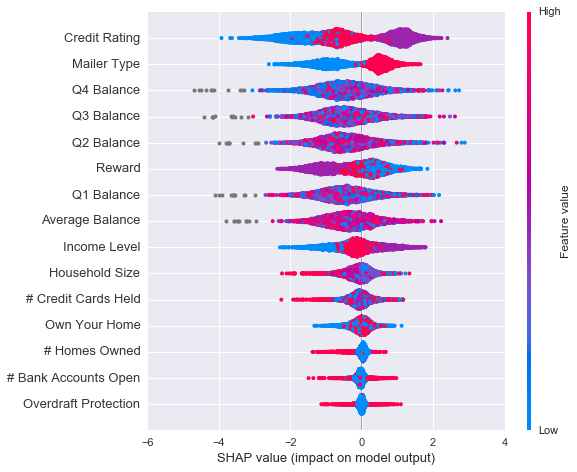

In [152]:
print(X_test.head())
shap.summary_plot(shap_values, X_test[:10000])